In [ ]:
! pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import lightgbm as lgb
import seaborn as sns
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer


random.seed(42)

In [ ]:
df_all = pd.read_csv('clean_df.csv')
df_all['time_close'] = pd.to_datetime(df_all['time_close'])
# df_all = df_all.loc[df_all['time_close'] > '2021-07-01']
df = df_all.loc[df_all['symbol_id'] == 'LTC_2'].copy().reset_index(drop=True)
symbols = ['DOGE_74', 'ETH_1027', 'XRP_52', 'XLM_512', 'BTC_1', 'XMR_328']
for sym in symbols:
    df[(sym)] = df_all.loc[df_all['symbol_id'] ==  sym]['price change'].values
df.drop(columns=['symbol_id', 'volume change', 'tomorrow change'], inplace=True)
cols = ['SPY', 'Oil', '10Y Treasury', 'Gold', 'EUR_USD', 'marketcap']
for col in cols:
    df[(col)] = df[col].pct_change()
df['target'] = df['close'].shift(-1)
# df["target"] = df["target"].diff(periods=1)
df["target"] = df["target"].pct_change()
df.dropna(inplace=True)
df.head()

,time_close,close,volume,marketcap,month,day,weekday,day of week,price change,SPY,...,Gold,Oil,EUR_USD,DOGE_74,ETH_1027,XRP_52,XLM_512,BTC_1,XMR_328,target
1,2020-09-25,44.790372,2.027335e+09,0.027996,9,25,4,1,0.027876,0.016167,...,-0.005674,-0.001488,0.001261,0.021075,0.078154,0.040102,0.023188,0.046477,0.037234,0.029021
2,2020-09-26,46.090238,1.852828e+09,0.029136,9,26,5,0,0.029021,0.000000,...,0.000000,0.000000,0.000000,0.027243,0.010122,0.049036,0.066801,-0.009782,0.014505,0.005422
3,2020-09-27,46.340146,2.191838e+09,0.005537,9,27,6,0,0.005422,0.000000,...,0.000000,0.000000,0.000000,0.007860,0.021704,-0.000456,-0.010805,0.009511,0.021696,0.002042
4,2020-09-28,46.434781,2.217909e+09,0.002156,9,28,0,1,0.002042,0.016609,...,0.008128,0.008696,-0.003246,0.005012,-0.002503,0.005170,-0.000851,0.010435,0.028372,-0.013785
5,2020-09-29,45.794669,1.904060e+09,-0.013669,9,29,1,1,-0.013785,-0.005446,...,0.011480,-0.032266,0.003737,-0.022978,-0.008407,-0.007553,-0.003863,-0.014901,-0.025720,-0.004501


In [ ]:
for col in df.columns[2:]:
  timeseries = df[col]
  result = adfuller(timeseries)
  print(f'ADF Statistic: {result[0]:.3f}')
  print(f'p-value: {result[1]:.3E}')
  if result[0] > result[4]["5%"]:
      conclusion=f"Failed to Reject H_0 at 5% -> {col} Time Series is Non-Stationary"
  else:
      conclusion=f"Reject H_0 at at 5% -> {col} Time Series is Stationary"
  print(conclusion)

ADF Statistic: -3.183
p-value: 2.097E-02
Reject H_0 at at 5% -> volume Time Series is Stationary
ADF Statistic: -27.103
p-value: 0.000E+00
Reject H_0 at at 5% -> marketcap Time Series is Stationary
ADF Statistic: -2.396
p-value: 1.428E-01
Failed to Reject H_0 at 5% -> month Time Series is Non-Stationary
ADF Statistic: -13.086
p-value: 1.832E-24
Reject H_0 at at 5% -> day Time Series is Stationary
ADF Statistic: -5.261
p-value: 6.595E-06
Reject H_0 at at 5% -> weekday Time Series is Stationary
ADF Statistic: -5.019
p-value: 2.035E-05
Reject H_0 at at 5% -> day of week Time Series is Stationary
ADF Statistic: -27.119
p-value: 0.000E+00
Reject H_0 at at 5% -> price change Time Series is Stationary
ADF Statistic: -11.976
p-value: 3.801E-22
Reject H_0 at at 5% -> SPY Time Series is Stationary
ADF Statistic: -4.268
p-value: 5.039E-04
Reject H_0 at at 5% -> VIX Time Series is Stationary
ADF Statistic: -5.052
p-value: 1.750E-05
Reject H_0 at at 5% -> 10Y Treasury Time Series is Stationary
ADF 

In [ ]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi
df['RSI'] = relative_strength_idx(df).fillna(0)

In [ ]:
EMA_12 = pd.Series(df['close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

In [ ]:
date = '2022-05-03'
price = df[['close', 'time_close']]
test_price = price.loc[price['time_close'] >= date].copy()
test_price.drop(columns='time_close', inplace = True)

In [ ]:
df.drop(columns=['close'], inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,time_close,volume,marketcap,month,day,weekday,day of week,price change,SPY,VIX,...,DOGE_74,ETH_1027,XRP_52,XLM_512,BTC_1,XMR_328,target,RSI,MACD,MACD_signal
0,2020-11-02,2.088399e+09,0.020483,11,2,0,1,0.020381,0.011208,37.130001,...,0.003971,0.039408,0.011965,0.012973,0.004747,0.012756,-0.046940,69.595794,1.977040,1.520857
1,2020-11-03,3.001203e+09,-0.046840,11,3,1,1,-0.046940,0.017656,35.549999,...,-0.019086,-0.047460,-0.029831,-0.038229,-0.019704,-0.071667,-0.001579,61.471615,1.869981,1.599081
2,2020-11-04,2.571256e+09,-0.001453,11,4,2,1,-0.001579,0.022349,29.570000,...,-0.006778,0.004886,0.013582,-0.004013,0.025553,0.016802,0.014579,61.753458,1.758317,1.633921
3,2020-11-05,3.030278e+09,0.014701,11,5,3,1,0.014579,0.019503,27.580000,...,0.015214,0.043862,-0.001521,-0.006539,0.018375,-0.038444,0.108201,71.990520,1.709907,1.650240
4,2020-11-06,3.513652e+09,0.108324,11,6,4,1,0.108201,-0.000228,24.860001,...,0.034446,0.052088,0.045339,0.085350,0.124291,0.043254,0.054511,79.749774,2.099825,1.745388


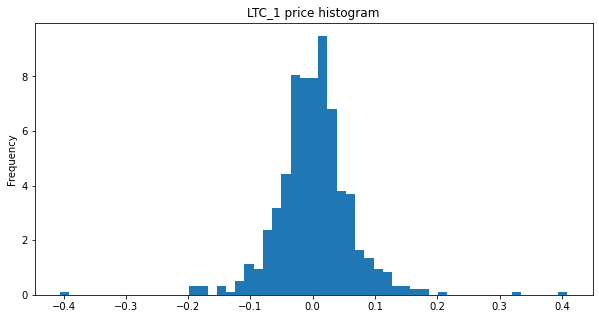

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
df['target'].plot.hist(density=1, bins=55, ax=ax)
plt.title('LTC_1 price histogram')
plt.show()

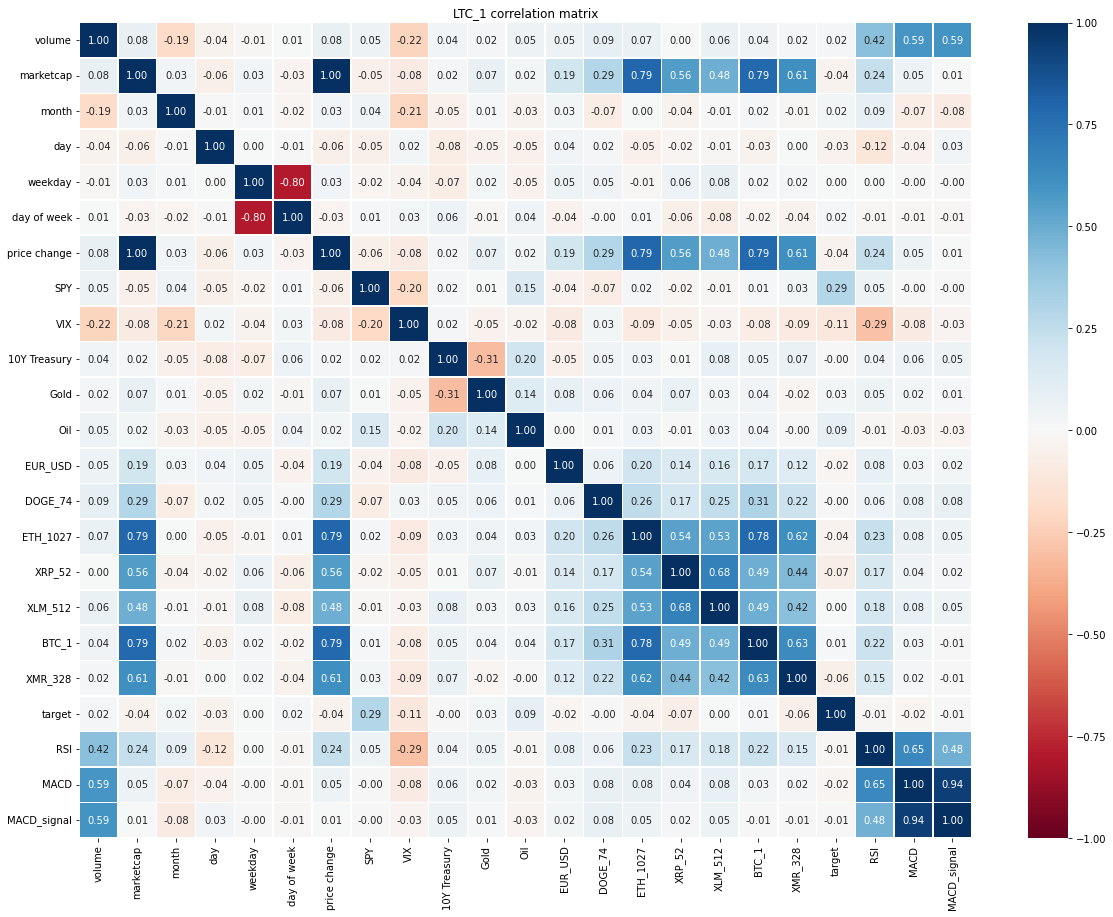

In [ ]:
fig, ax = plt.subplots(figsize = (20, 15))
corrmat = df.drop(columns='time_close').corr()
sns.heatmap(corrmat, cmap="RdBu", linewidths=.5, vmin=-1, vmax=1, annot=True, fmt='.2f')
plt.title('LTC_1 correlation matrix')
plt.show()

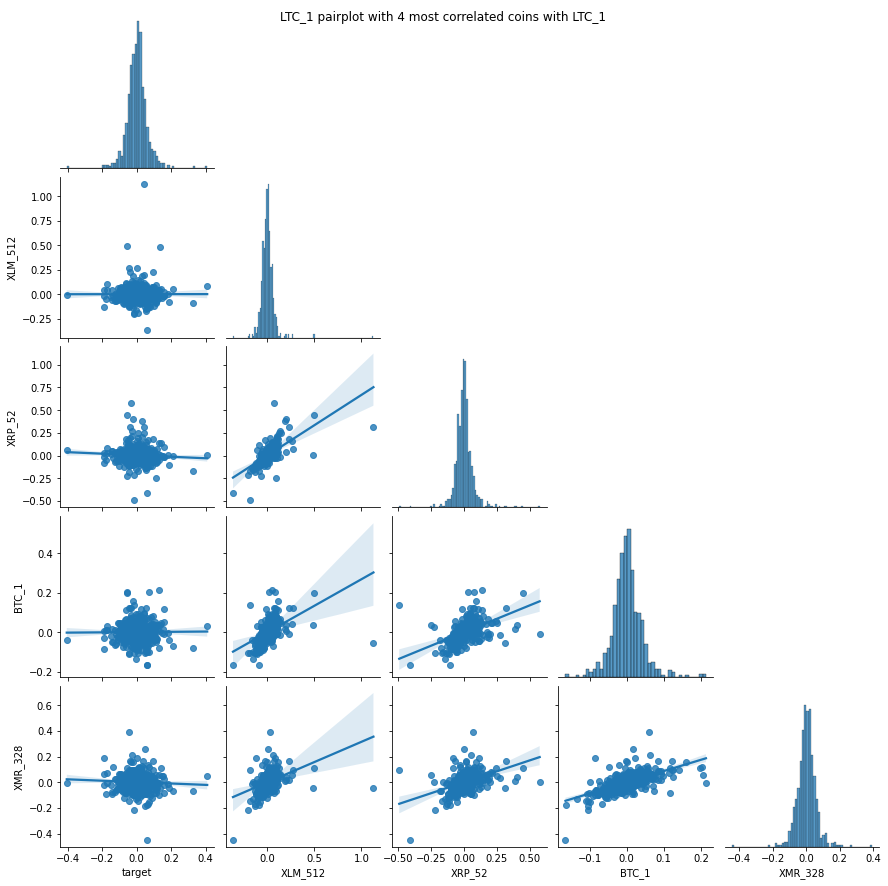

In [ ]:
sns.pairplot(df[['target', 'XLM_512', 'XRP_52', 'BTC_1', 'XMR_328']], kind='reg', corner=True)
plt.suptitle('LTC_1 pairplot with 4 most correlated coins with LTC_1')
plt.show()

In [ ]:
y = df[['target', 'time_close']]
x = df.drop(columns=['target'])

In [ ]:
x_train = x.loc[x['time_close'] < date].copy()
x_test = x.loc[x['time_close'] >= date].copy()
y_train = y.loc[y['time_close'] < date].copy()
y_test = y.loc[y['time_close'] >= date].copy()

In [ ]:
x_train.drop(columns='time_close', inplace = True)
x_test.drop(columns='time_close', inplace = True)

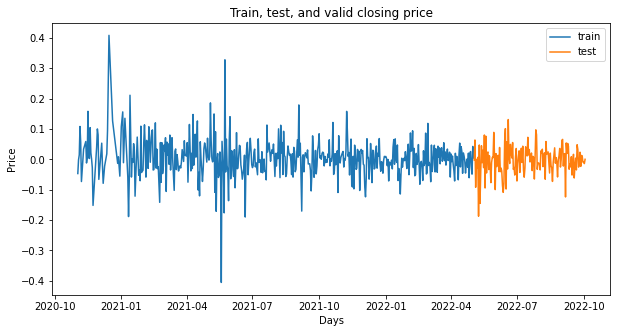

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(y_train.time_close, y_train.target, label='train')
plt.plot(y_test.time_close, y_test.target, label='test')
plt.ylabel('Price')
plt.xlabel('Days')
plt.title('Train, test, and valid closing price')
plt.legend()
plt.show()

In [ ]:
lower, upper = y_train.target.quantile([.25, .75])

In [ ]:
train_dates = y_train['time_close'].values
test_dates = y_test['time_close'].values

y_train.drop(columns=['time_close'], inplace=True)
y_test.drop(columns=['time_close'], inplace=True)

In [ ]:
y_test_c = np.where(y_test < lower, 0, np.where(y_test <= upper, 1, 2))
y_train_c = np.where(y_train < lower, 0, np.where(y_train <= upper, 1, 2))

In [ ]:
print((y_train_c == 0).sum())
print((y_train_c == 1).sum())
print((y_train_c == 2).sum())

126
250
126


In [ ]:
print((y_test_c == 0).sum())
print((y_test_c == 1).sum())
print((y_test_c == 2).sum())

36
85
32


In [ ]:
param_grid = {'n_estimators':[5, 10, 25, 35, 45, 55, 75, 100]}
reg = lgb.LGBMClassifier()
grid = GridSearchCV(estimator = reg, param_grid = param_grid, scoring = 'f1_macro', cv = 5, verbose = 1, return_train_score= True)
grid.fit(x_train, y_train_c.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'n_estimators': [5, 10, 25, 35, 45, 55, 75, 100]},
             return_train_score=True, scoring='f1_macro', verbose=1)

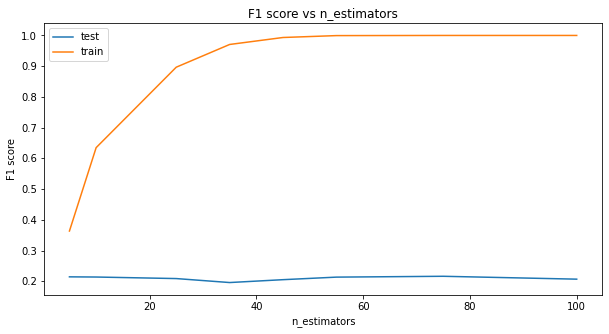

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(param_grid['n_estimators'], grid.cv_results_['mean_test_score'], label='test')
plt.plot(param_grid['n_estimators'], grid.cv_results_['mean_train_score'], label='train')
plt.ylabel('F1 score')
plt.xlabel('n_estimators')
plt.title('F1 score vs n_estimators')
plt.legend()
plt.show()

In [ ]:
best_reg = lgb.LGBMClassifier(n_estimators = 55)
best_reg.fit(x_train, y_train_c.ravel())

LGBMClassifier(n_estimators=55)

In [ ]:
pred = best_reg.predict(x_test)
pred_proba = best_reg.predict_proba(x_test)

In [ ]:
def scores(y_true, y_pred, pred_proba):
  acc = metrics.accuracy_score(y_true, y_pred)
  prec = metrics.precision_score(y_true, y_pred, average = 'weighted')
  rec = metrics.recall_score(y_true, y_pred, average = 'weighted')
  f1 = metrics.f1_score(y_true, y_pred, average = 'macro')
  roc_auc = metrics.roc_auc_score(np.squeeze((np.eye(4)[y_true]),1), pred_proba)

  print('Accuracy is :',round(acc,3))
  print('Precision is :',round(prec,3))
  print('Recall is :',round(rec,3))
  print('F1 score is :',round(f1,3))
  print('AUC is :',round(roc_auc,3))

In [ ]:
scores(y_test_c, pred, pred_proba)

Accuracy is : 0.627
Precision is : 0.632
Recall is : 0.627
F1 score is : 0.508
AUC is : 0.681


In [ ]:
train_pred = best_reg.predict(x_train)
print('Train accuracy is :', metrics.accuracy_score(y_train_c, train_pred))
print('Train precision is :', metrics.precision_score(y_train_c, train_pred, average = 'weighted'))
print('Train precision is :', metrics.f1_score(y_train_c, train_pred, average = 'macro'))

Train accuracy is : 1.0
Train precision is : 1.0
Train precision is : 1.0


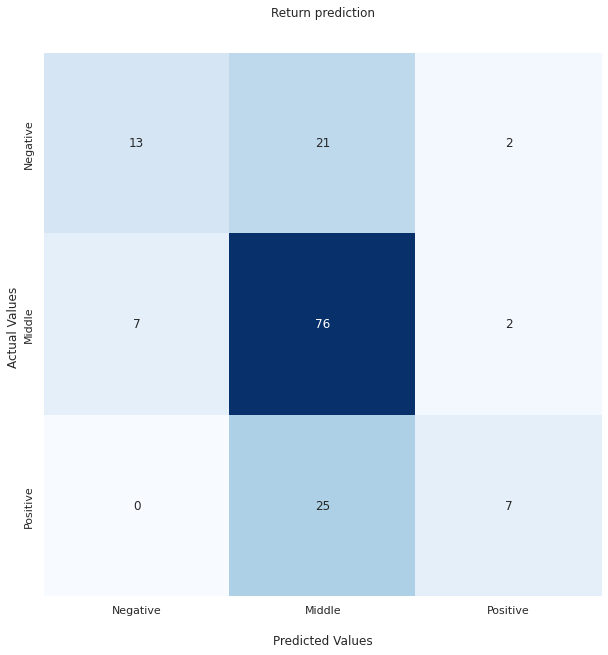

In [ ]:
cf_matrix = metrics.confusion_matrix(y_test_c, pred)

sns.set(rc={'figure.figsize':(10,10)})

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',cbar=False,fmt = 'g')

ax.set_title('Return prediction\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Negative', 'Middle', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Middle', 'Positive'])

plt.show()

In [ ]:
sns.reset_orig()

In [ ]:
guess_neg = np.nonzero(np.where(pred == 0, 1, 0))
guess_pos = np.nonzero(np.where(pred == 2, 1, 0))
y_test.reset_index(drop=True, inplace=True)
negative = y_test.iloc[guess_neg]
correct_neg = negative.loc[negative.target < lower]
positive = y_test.iloc[guess_pos]
correct_pos = positive.loc[positive.target > upper]

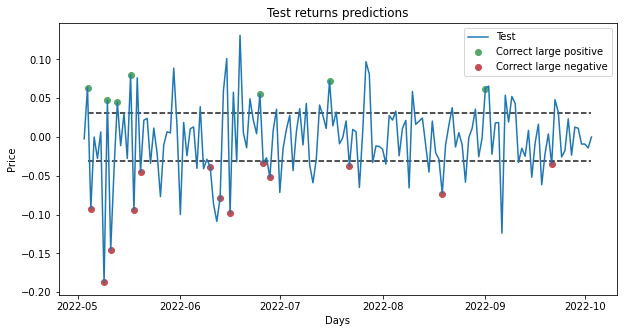

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(test_dates, y_test.target, label='Test')
plt.scatter(test_dates[correct_pos.index], y_test.iloc[correct_pos.index], c='g', marker = 'o', label='Correct large positive')
plt.scatter(test_dates[correct_neg.index], y_test.iloc[correct_neg.index], c='r', marker = 'o',label='Correct large negative')
ax.hlines(y=upper, xmin=test_dates[1], xmax=test_dates[-1], color='k', linestyles='dashed')
ax.hlines(y=lower, xmin=test_dates[1], xmax=test_dates[-1], color='k', linestyles='dashed')
plt.ylabel('Price')
plt.xlabel('Days')
plt.title('Test returns predictions')
plt.legend()
plt.show()

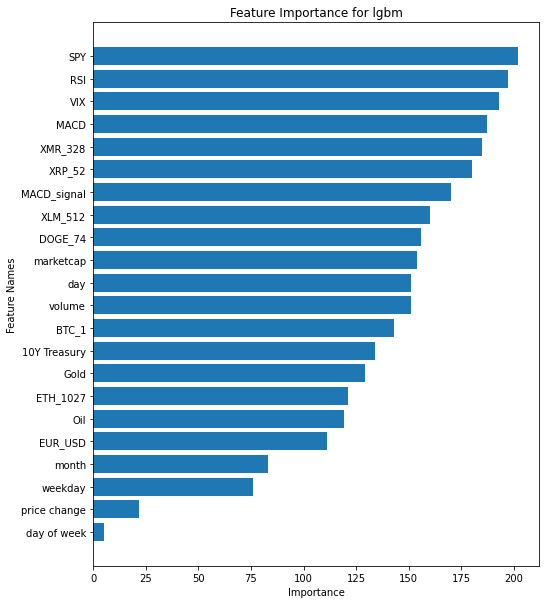

In [ ]:
importance = best_reg.feature_importances_.copy()
sorted_import = importance.argsort()
fig, ax = plt.subplots(figsize = (8, 10))
plt.barh(x_train.columns[sorted_import], importance[sorted_import])
plt.xlabel('Importance')
plt.ylabel('Feature Names')
plt.title('Feature Importance for lgbm')
plt.show()

In [ ]:
def apply_strategy(pred, test_price):
  money = [0]
  idx =[]
  shares = [1000 / float(test_price.values[0])]
  for i in range(len(pred)):
      current_signal = pred[i]
      if i == 0:
        previous_signal = 1
      else:
        previous_signal = pred[i-1]
      if current_signal > 0:
        if previous_signal == 0: # buy
          shares.append(money[-1]/float(test_price.values[i]))
          money.append(0)
        else:
          money.append(money[-1])
          shares.append(shares[-1])
          if money[-1] > 0:
            idx.append(i)
      else:
        if previous_signal > 0: #sell
          money.append(shares[-1] * float(test_price.values[i]))
          shares.append(0)
          if money[-1] > 0:
            idx.append(i)
        else:
          money.append(money[-1])
          shares.append(shares[-1])
          if money[-1] > 0:
            idx.append(i)
      if i == len(pred)-1:
        if money[-1] == 0:
          money.append(shares[-1] * float(test_price.values[i]))
          shares.append(0)
  return money, idx

In [ ]:
money, idx = apply_strategy(pred, test_price)
money = np.array(money)
money = money[money != 0]
money[-1]

1585.7759590927478

In [ ]:
(1000 / float(test_price.values[0]))*float(test_price.values[-1])

519.3747417374369

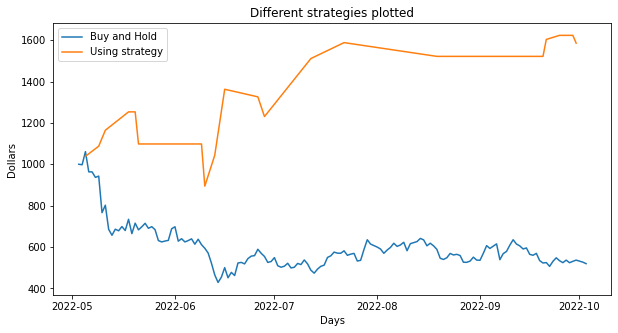

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(test_dates, (1000 / float(test_price.values[0])*test_price.values), label='Buy and Hold')
plt.plot(test_dates[idx], money[1:], label='Using strategy')
plt.ylabel('Dollars')
plt.xlabel('Days')
plt.title('Different strategies plotted')
plt.legend()
plt.show()